# Experiments from paper

In this noteboook, we perform a brief numerical illustration of the Gauss-Newton-Polyak method. We focus on low-rank tensor recovery problems of the form
\begin{align}
\min_{X \in \mathbb{R}^{d \times r}} h(c(X)) := \|\mathcal{A}(c(X)) - b\|_1,
\end{align}
where $r\leq d$ denotes the "rank" of the problem; $c\colon \mathbb{R}^{d\times r} \rightarrow \mathbb{R}^{d^n}$ is a smooth mapping into the space of $n$-th order tensors; $\mathcal{A}\colon \mathbb{R}^{d^n}\rightarrow \mathbb{R}^m$ is a linear operator; $b = \mathcal{A}(c(X_\star)) + \epsilon$ is a (noisy) measurement of a fixed full-rank matrix $X_\star \in \mathbb{R}^{d \times r}$ with random  $\epsilon \in \mathbb{R}^m$; and $h\colon \mathbb{R}^{d^n} \rightarrow \mathbb{R}$ is the fixed penalty function $h(M) = \|\mathcal{A}(M) - b\|_1$.

More specifically, throughout this notebook, $c$ takes the form:
$$
c(X) = \sum_{i=1}^r x_i^{\otimes n},
$$
where $x_i$ denotes the $i$th column of $X \in \mathbb{R}^{d\times r}$. Next, the linear mapping $\mathcal{A} \colon \mathbb{R}^{d^n} \rightarrow \mathbb{R}^m$ is constructed from $2m$ Gaussian vectors $p_i, q_i$; on any tensor $M$ it returns
$$
\mathcal{A}(M) := (M(p_i^{\otimes n}) -  M(q_i^{\otimes n}))_{i=1}^m ,
$$
where $M(p_i^{\otimes n})$ denotes the evaluation of $M$ on $p_i^{\otimes n}$, etc. Finally, we choose noise vector $\epsilon$ in the following way: First we fix a "failure probability" $p_{\mathrm{fail}} \in [0, 1/2)$. Then for each $i$, we independently sample $\epsilon_i$ from a standard Gaussian with probability $p_{\mathrm{fail}}$ or set $\epsilon_i$ to $0$ probability $1-p_{\mathrm{fail}}$.

## Varying the rank r

In this experiment, we vary the rank $r$, while fixing $n = 3$, $p_{\mathrm{fail}} = 0$, $d = 100$, and $m = 8ndr$, and $\kappa(X_\star) = 3$. We compare $\texttt{gnp}$ to the $\texttt{polyak}$. We observe that $\texttt{gnp}$ outperforms $\texttt{polyak}$ in both time and oracle

In [15]:
import GNP
import matplotlib.pyplot as plt
import utils
import problems
import time


d = 100
# r = 1
n = 3
delta = 1e-1
pfail = 0
LSMR_tol = 1e-30
nb_iters = 10000
nb_restarts=1
tol = 1e-8
cond_num = 3
# cond_nums = [1, 10, 100]
# ns = [2, 4, 8]
methods = ["Polyak", "GNP"]
# pfails = [.25, .4]
rs = [5, 10, 15]
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of losses as values
losses_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of times as values
times_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of relative distances as values
rel_distance_in_range_dict = {}
# a dictionary with the opt_vals
opt_vals = {}

linsys_solver= GNP.LinearSystemSolver.LSMR
for r in rs:
    m = 8*n*d*r
    problem = problems.TensorSensingProblem(d=d, r=r, m=m, n=n, pfail=pfail, cond_num=cond_num)
    X = problem.initializer(delta)
    loss_func = problem.loss()
    def f():
        return loss_func(X)
    opt_val = loss_func(problem.X_star)
    Y = X.clone().detach().requires_grad_(True)
    for method in methods:
        opt_vals[(method, r)] = opt_val
        # Print the method and the condition number with their labels
        print(method, r)
        X = Y.clone().detach().requires_grad_(True)
        JacTJac = problem.JacTJac(method, X)
        def rel_distance_in_range():
            return problem.rel_dist_in_range(X)

        def closure():
            optimizer.zero_grad()
            loss = f()
            loss.backward()
            return loss
        optimizer = GNP.GNP([X], LSMR_tol=LSMR_tol, linsys_solver=linsys_solver)

        start = time.time()
        # nb_restarts = nb_restarts_dict[method]
        # nb_iters = nb_iters_dict[method]
        losses, times, rel_distance_in_range_hist = utils.restarted_method(optimizer=optimizer, closure=closure, rel_distance_in_range=rel_distance_in_range, JacTJac=JacTJac, nb_iters=nb_iters, nb_restarts=nb_restarts, lb = 0, tol=tol)
        losses_dict[(method, r)] = losses
        times_dict[(method, r)] = times
        rel_distance_in_range_dict[(method, r)] = rel_distance_in_range_hist



Polyak 5
GNP 5
Polyak 10
lb 3.155687697611875e-08
GNP 10
Polyak 15
lb 6.956950038168597e-07
GNP 15


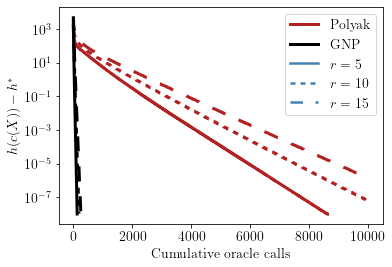

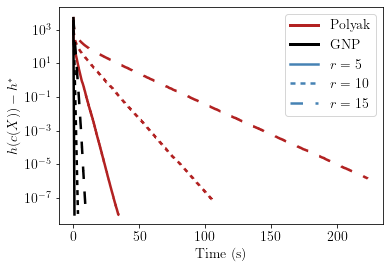

In [17]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
})
plt.rcParams.update({'font.size': 14})
# make a dictionary of colors for the methods
colors = {"Polyak": "firebrick", "ScaledSM": "firebrick", "GNP": "black"}
# make a dictionary of markers for the condition numbers
markers = {1: "o", 10: "s", 100: "^"}
# instead of markers do a different kind of dashes
dashes = {rs[0]: (None, None), rs[1]: (2, 2), rs[2]: (5, 5)}

for method in methods:
    for r in rs:
        # a list that subtracts the optimal value from the losses_dict[(method, pfail)]
        losses = [loss - opt_vals[(method, r)] for loss in losses_dict[(method, r)]]
        plt.semilogy(losses, color=colors[method], dashes=dashes[r], linewidth=3)
plt.xlabel("Cumulative oracle calls")
plt.ylabel(r"$h(c(X)) - h^\ast$")
# legend
# make a list of lines for the legend
lines = []
# make a list of labels for the legend
labels = []
# iterate over the methods
# need to import the matplotlib.lines.Line2D
from matplotlib.lines import Line2D
for method in methods:
    # make a line for the method
    line = Line2D([0], [0], color=colors[method], linewidth=3)

    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(method)
# iterate over the condition numbers
for r in rs:
    # make a line for the condition number
    line = Line2D([0], [0], color="steelblue", dashes=dashes[r], linewidth=2.5)
    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(r"$r = " + str(r) + "$")
plt.legend(lines, labels, loc="upper right")
# plt.legend(loc="lower right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_oracle_calls
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment4_polyak_vs_gnp_oracle_calls.pdf")
# provide a bit more room on the left so the label is not cut off
plt.show()

# make the legend
for method in methods:
    for r in rs:
        losses = [loss - opt_vals[(method, r)] for loss in losses_dict[(method, r)]]
        plt.semilogy(times_dict[(method,r)], losses, color=colors[method], dashes=dashes[r], linewidth=2.5)
plt.xlabel("Time (s)")
plt.ylabel(r"$h(c(X)) - h^\ast$")
plt.legend(lines,labels, loc="upper right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_time
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment4_polyak_vs_gnp_time.pdf")
plt.show()

## Varying the order of the tensor $n$

In this experiment, we vary the order $n$ of the tensor. We set $r=5$, $p_{\mathrm{fail}} = 0$, $m = 8ndr$. We set $\kappa = 3$ and $d = 100$; we set the maximal number of oracle calls for each run to be $10000$. We see that in all cases, $\texttt{gnp}$ outperforms $\texttt{polyak}$.


In [4]:
import GNP
import matplotlib.pyplot as plt
import utils
import problems
import time


d = 100
r = 5
# n = 2
delta = 1e-2
pfail = 0
LSMR_tol = 1e-30
nb_iters = 1000
nb_restarts=1
tol = 1e-8
cond_num = 3
# cond_nums = [1, 10, 100]
ns = [2, 4, 6]
methods = ["Polyak", "GNP"]
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of losses as values
losses_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of times as values
times_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of relative distances as values
rel_distance_in_range_dict = {}
linsys_solver=GNP.LinearSystemSolver.LSMR
# set up a cprofile here
# import cProfile

# pr = cProfile.Profile()
# pr.enable()



for n in ns:
    m = 8*n*d*r
    problem = problems.TensorSensingProblem(d=d, r=r, m=m, n=n, pfail=pfail, cond_num=cond_num)
    X = problem.initializer(delta)
    loss_func = problem.loss()
    def f():
        return loss_func(X)
    opt_val = loss_func(problem.X_star)
    Y = X.clone().detach().requires_grad_(True)
    for method in methods:
        # Print the method and the condition number with their labels
        print(method, n)
        X = Y.clone().detach().requires_grad_(True)
        JacTJac = problem.JacTJac(method, X)
        def rel_distance_in_range():
            return problem.rel_dist_in_range(X)

        def closure():
            optimizer.zero_grad()
            loss = f()
            loss.backward()
            return loss
        optimizer = GNP.GNP([X], LSMR_tol=LSMR_tol, linsys_solver=linsys_solver)

        start = time.time()
        losses, times, rel_distance_in_range_hist = utils.restarted_method(optimizer=optimizer, closure=closure, rel_distance_in_range=rel_distance_in_range, JacTJac=JacTJac, nb_iters=nb_iters, nb_restarts=nb_restarts, lb = 0, tol=tol)
        losses_dict[(method, n)] = losses
        times_dict[(method, n)] = times
        rel_distance_in_range_dict[(method, n)] = rel_distance_in_range_hist

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
})
plt.rcParams.update({'font.size': 14})

# save the cprofile results
# pr.disable()
# pr.dump_stats("Experiment2_polyak_vs_gnp.pstat")


Polyak 2
GNP 2
Polyak 4
lb 5.171846644798846
GNP 4
Polyak 6
lb 64.6953333928077
GNP 6


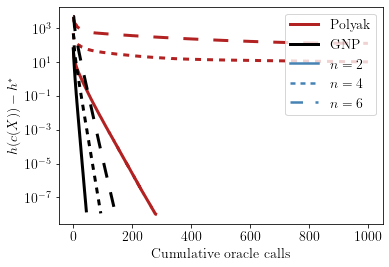

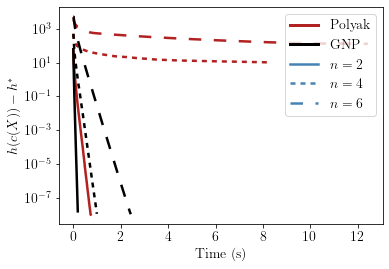

In [5]:
# make a dictionary of colors for the methods
colors = {"Polyak": "firebrick", "ScaledSM": "firebrick", "GNP": "black"}
# make a dictionary of markers for the condition numbers
markers = {1: "o", 10: "s", 100: "^"}
# instead of markers do a different kind of dashes
dashes = {ns[0]: (None, None), ns[1]: (2, 2), ns[2]: (5, 5)}

for method in methods:
    for n in ns:
        plt.semilogy(losses_dict[(method, n)], color=colors[method], dashes=dashes[n], linewidth=3)
# plt.xlim(0, 140)
plt.xlabel("Cumulative oracle calls")
plt.ylabel(r"$h(c(X)) - h^\ast$")
# legend
# make a list of lines for the legend
lines = []
# make a list of labels for the legend
labels = []
# iterate over the methods
# need to import the matplotlib.lines.Line2D
from matplotlib.lines import Line2D
for method in methods:
    # make a line for the method
    line = Line2D([0], [0], color=colors[method], linewidth=3)

    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(method)
# iterate over the condition numbers
for n in ns:
    # make a line for the condition number
    line = Line2D([0], [0], color="steelblue", dashes=dashes[n], linewidth=2.5)
    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(r"$n = " + str(n) + "$")
plt.legend(lines, labels, loc="upper right")
# plt.legend(loc="lower right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_oracle_calls
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment5_polyak_vs_gnp_oracle_calls.pdf")
# provide a bit more room on the left so the label is not cut off
plt.show()

# make the legend
for method in methods:
    for n in ns:
        plt.semilogy(times_dict[(method, n)], losses_dict[(method, n)], color=colors[method], dashes=dashes[n], linewidth=2.5)
plt.xlabel("Time (s)")
# cut off the plot to below times = 100 seconds
# plt.xlim(0, 100)
plt.ylabel(r"$h(c(X)) - h^\ast$")
plt.legend(lines,labels, loc="upper right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_time
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment5_polyak_vs_gnp_time.pdf")
plt.show()

# Unknown optimal value and noise in the measurements

In this experiment, we vary $p_{\mathrm{fail}}$, while fixing $\kappa(X_\star) = 5$, $d=100$, $n=2$, $r=5$, and $m = 8dr$. In this case, the optimal value $h^\ast$ is unknown, so we instead $\texttt{RGNP}$ to the $\texttt{RPolyak}$ with an initial guess of $h_0 = 0$. In addition, we set the total inner loop size $T$ and the number of restarts $K$ differently for both methods. For $\texttt{RGNP}$, we $T = 200$ and $K = 50$. For $\texttt{RPolyak}$, we set $T=1000$ and $K=10$. Our rationale for these numbers is the following: First, we would like to cap the total number of oracle calls by $TK = 10000$. Second, we ensure $T$ is large enough that non-restarted methods $\texttt{GNP}$ and $\texttt{polyak}$ would perform well. Finally, we set $K$ so that it exhausts the remaining budget of oracle calls. We see that both methods eventually reach $10^{-8}$ objective error. In addition, $\texttt{GNP}$ continues to outperform $\texttt{polyak}$.

In [2]:
import GNP
import matplotlib.pyplot as plt
import utils
import problems
import time


d = 100
r = 5
n = 2
delta = 1e-1
pfail = 0
LSMR_tol = 1e-30
nb_iters = 1200
nb_restarts=10
tol = 1e-8
cond_num = 5
# cond_nums = [1, 10, 100]
# ns = [2, 4, 8]
methods = ["RPolyak", "RGNP"]
pfails = [.25, .4]
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of losses as values
losses_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of times as values
times_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of relative distances as values
rel_distance_in_range_dict = {}
# a dictionary with the opt_vals
opt_vals = {}
# a dictionary with method as key and the number of iterations as value
nb_iters_dict = {}
nb_iters_dict["RPolyak"] = 1200
nb_iters_dict["RGNP"] = 200
nb_restarts_dict = {}
nb_restarts_dict["RPolyak"] = 10000//750
nb_restarts_dict["RGNP"] = 50
linsys_solver=GNP.LinearSystemSolver.LSMR
for pfail in pfails:
    m = 8*n*d*r
    problem = problems.TensorSensingProblem(d=d, r=r, m=m, n=n, pfail=pfail, cond_num=cond_num)
    X = problem.initializer(delta)
    loss_func = problem.loss()
    def f():
        return loss_func(X)
    opt_val = loss_func(problem.X_star)
    Y = X.clone().detach().requires_grad_(True)
    for method in methods:
        opt_vals[(method, pfail)] = opt_val
        # Print the method and the condition number with their labels
        print(method, pfail)
        X = Y.clone().detach().requires_grad_(True)
        JacTJac = problem.JacTJac(method, X)
        def rel_distance_in_range():
            return problem.rel_dist_in_range(X)

        def closure():
            optimizer.zero_grad()
            loss = f()
            loss.backward()
            return loss
        optimizer = GNP.GNP([X], LSMR_tol=LSMR_tol, linsys_solver=linsys_solver)

        start = time.time()
        nb_restarts = nb_restarts_dict[method]
        nb_iters = nb_iters_dict[method]
        losses, times, rel_distance_in_range_hist = utils.restarted_method(optimizer=optimizer, closure=closure, rel_distance_in_range=rel_distance_in_range, JacTJac=JacTJac, nb_iters=nb_iters, nb_restarts=nb_restarts, lb = 0, tol=tol)
        losses_dict[(method, pfail)] = losses
        times_dict[(method, pfail)] = times
        rel_distance_in_range_dict[(method, pfail)] = rel_distance_in_range_hist

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
})
plt.rcParams.update({'font.size': 14})


RPolyak 0.25
lb 0.7480584195026586
lb 0.8049500668745759
lb 0.8070330910397437
lb 0.8070899884728173
lb 0.8070914297680423
lb 0.8070914691329379
RGNP 0.25
lb 0.7515807163454715
lb 0.8053270452278611
lb 0.8070352587455949
lb 0.8070897615089011
lb 0.8070913902382724
lb 0.8070914674568896
RPolyak 0.4
lb 1.0960358643897394
lb 1.2634967724313868
lb 1.281939659436861
lb 1.2826540960254622
lb 1.2826785831623633
lb 1.2826794096386003
lb 1.2826794340590648
RGNP 0.4
lb 1.1143088262423229
lb 1.2692632453593093
lb 1.281863345972018
lb 1.2826538419368667
lb 1.2826786395335772
lb 1.2826794034195648
lb 1.282679433137719


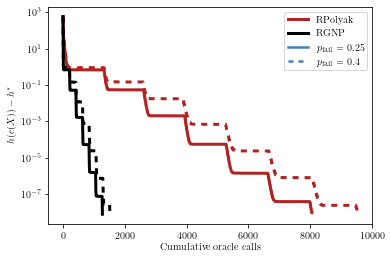

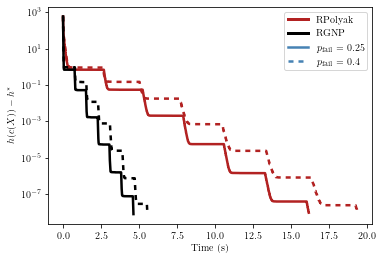

In [3]:
# make a dictionary of colors for the methods
colors = {"RPolyak": "firebrick", "RScaledSM": "firebrick", "RGNP": "black"}
# make a dictionary of markers for the condition numbers
markers = {1: "o", 10: "s", 100: "^"}
# instead of markers do a different kind of dashes
dashes = {pfails[0]: (None, None), pfails[1]: (2, 2)}

for method in methods:
    for pfail in pfails:
        # a list that subtracts the optimal value from the losses_dict[(method, pfail)]
        losses = [loss - opt_vals[(method, pfail)] for loss in losses_dict[(method, pfail)]]
        plt.semilogy(losses, color=colors[method], dashes=dashes[pfail], linewidth=3)
plt.xlabel("Cumulative oracle calls")
plt.ylabel(r"$h(c(X)) - h^\ast$")
# legend
# make a list of lines for the legend
lines = []
# make a list of labels for the legend
labels = []
# iterate over the methods
# need to import the matplotlib.lines.Line2D
from matplotlib.lines import Line2D
for method in methods:
    # make a line for the method
    line = Line2D([0], [0], color=colors[method], linewidth=3)

    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(method)
# iterate over the condition numbers
for pfail in pfails:
    # make a line for the condition number
    line = Line2D([0], [0], color="steelblue", dashes=dashes[pfail], linewidth=2.5)
    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(r"$p_{\mathrm{fail}} = " + str(pfail) + "$")
plt.legend(lines, labels, loc="upper right")
# plt.legend(loc="lower right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_oracle_calls
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment3_polyak_vs_gnp_oracle_calls.pdf")
# provide a bit more room on the left so the label is not cut off
plt.show()

# make the legend
for method in methods:
    for pfail in pfails:
        losses = [loss - opt_vals[(method, pfail)] for loss in losses_dict[(method, pfail)]]
        plt.semilogy(times_dict[(method,pfail)], losses, color=colors[method], dashes=dashes[pfail], linewidth=2.5)
plt.xlabel("Time (s)")
plt.ylabel(r"$h(c(X)) - h^\ast$")
plt.legend(lines,labels, loc="upper right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_time
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment3_polyak_vs_gnp_time.pdf")
plt.show()

# Varying the condition number $\kappa$: $\texttt{GNP}$ vs $\texttt{Polyak}$

In this experiment, we vary the condition number $\kappa := \kappa(X_\star)$, while fixing $n = 2$, $r=5$, $p_{\mathrm{fail}} = 0$, $d = 1000$, and $m = 8dr$. We compare $\texttt{gnp}$ to the $\texttt{Polyak}$. As expected, $\texttt{GNP}$ outperform $\texttt{Polyak}$ when $\kappa > 1$.

In [9]:
import GNP
import matplotlib.pyplot as plt
import utils
import problems
import time


d = 1000
r = 5
n = 2
m = 8*d*r
delta = 1e-1
pfail = 0
LSMR_tol = 1e-30
nb_iters = 1000
nb_restarts=1
tol = 1e-15
cond_nums = [1, 10, 100]
methods = ["Polyak", "GNP"]
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of losses as values
losses_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of times as values
times_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of relative distances as values
rel_distance_in_range_dict = {}
linsys_solver=GNP.LinearSystemSolver.LSMR
for cond_num in cond_nums:
    problem = problems.TensorSensingProblem(d=d, r=r, m=m, n=n, pfail=pfail, cond_num=cond_num)
    X = problem.initializer(delta)
    loss_func = problem.loss()
    def f():
        return loss_func(X)
    opt_val = loss_func(problem.X_star)
    Y = X.clone().detach().requires_grad_(True)
    for method in methods:
        # Print the method and the condition number with their labels
        print(method, cond_num)
        X = Y.clone().detach().requires_grad_(True)
        JacTJac = problem.JacTJac(method, X)
        def rel_distance_in_range():
            return problem.rel_dist_in_range(X)

        def closure():
            optimizer.zero_grad()
            loss = f()
            loss.backward()
            return loss
        optimizer = GNP.GNP([X], LSMR_tol=LSMR_tol, linsys_solver=linsys_solver)

        start = time.time()
        losses, times, rel_distance_in_range_hist = utils.restarted_method(optimizer=optimizer, closure=closure, rel_distance_in_range=rel_distance_in_range, JacTJac=JacTJac, nb_iters=nb_iters, nb_restarts=nb_restarts, lb = 0, tol=1e-15)
        losses_dict[(method, cond_num)] = losses
        times_dict[(method, cond_num)] = times
        rel_distance_in_range_dict[(method, cond_num)] = rel_distance_in_range_hist

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
})
plt.rcParams.update({'font.size': 14})


Polyak 1
lb 1.321782752694567e-10
GNP 1
lb 1.3403600798711501e-10
Polyak 10
lb 0.3142037526356452
GNP 10
lb 6.810757773728637e-11
Polyak 100
lb 9.141711292582002
GNP 100
lb 6.51623299589843e-11


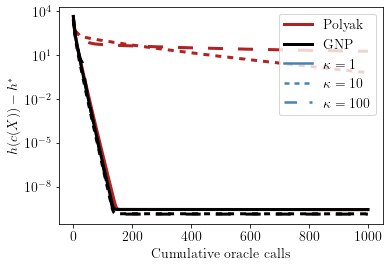

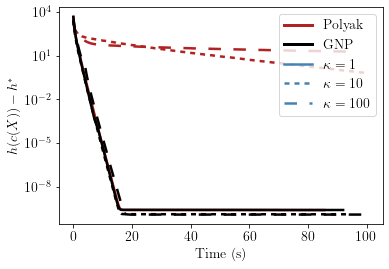

In [10]:
# make a dictionary of colors for the methods
colors = {"Polyak": "firebrick", "ScaledSM": "firebrick", "GNP": "black"}
# make a dictionary of markers for the condition numbers
markers = {1: "o", 10: "s", 100: "^"}
# instead of markers do a different kind of dashes
dashes = {1: (None, None), 10: (2, 2), 100: (5, 5)}

for method in methods:
    for cond_num in cond_nums:
        plt.semilogy(losses_dict[(method, cond_num)], color=colors[method], dashes=dashes[cond_num], linewidth=3)
plt.xlabel("Cumulative oracle calls")
plt.ylabel(r"$h(c(X)) - h^\ast$")
# legend
# make a list of lines for the legend
lines = []
# make a list of labels for the legend
labels = []
# iterate over the methods
# need to import the matplotlib.lines.Line2D
from matplotlib.lines import Line2D
for method in methods:
    # make a line for the method
    line = Line2D([0], [0], color=colors[method], linewidth=3)

    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(method)
# iterate over the condition numbers
for cond_num in cond_nums:
    # make a line for the condition number
    line = Line2D([0], [0], color="steelblue", dashes=dashes[cond_num], linewidth=2.5)
    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(r"$\kappa = " + str(cond_num) + "$")
plt.legend(lines, labels, loc="upper right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_oracle_calls
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment1_polyak_vs_gnp_oracle_calls.pdf")
# provide a bit more room on the left so the label is not cut off
plt.show()

# make the legend
for method in methods:
    for cond_num in cond_nums:
        plt.semilogy(times_dict[(method, cond_num)], losses_dict[(method, cond_num)], color=colors[method], dashes=dashes[cond_num], linewidth=2.5)
plt.xlabel("Time (s)")
plt.ylabel(r"$h(c(X)) - h^\ast$")
plt.legend(lines,labels, loc="upper right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_time
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment1_polyak_vs_gnp_time.pdf")
plt.show()

# Varying the condition number $\kappa$: $\texttt{gnp}$ vs $\texttt{ScaledSM}$

In this experiment, we vary the condition number $\kappa := \kappa(X_\star)$, while fixing $n = 2$, $r=5$, $p_{\mathrm{fail}} = 0$, $d = 1000$, and $m = 8dr$. We compare $\texttt{gnp}$ to the $\texttt{ScaledSM}$. We observe that $\texttt{GNP}$ performs comparably to $\texttt{ScaledSM}$ in both time and oracle complexity.

In [1]:
import GNP
import matplotlib.pyplot as plt
import utils
import problems
import time


d = 1000
r = 5
n = 2
m = 8*d*r
delta = 1e-1
pfail = 0
LSMR_tol = 1e-30
nb_iters = 100
nb_restarts=1
tol = 1e-15
cond_nums = [1, 10, 100]
methods = ["ScaledSM", "GNP"]
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of losses as values
losses_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of times as values
times_dict = {}
# a dictionary with "Polyak", "ScaledSM", "GNP" as keys and lists of relative distances as values
rel_distance_in_range_dict = {}
linsys_solver=GNP.LinearSystemSolver.LSMR
for cond_num in cond_nums:
    problem = problems.TensorSensingProblem(d=d, r=r, m=m, n=n, pfail=pfail, cond_num=cond_num)
    X = problem.initializer(delta)
    loss_func = problem.loss()
    def f():
        return loss_func(X)
    opt_val = loss_func(problem.X_star)
    Y = X.clone().detach().requires_grad_(True)
    for method in methods:
        # Print the method and the condition number with their labels
        print(method, cond_num)
        X = Y.clone().detach().requires_grad_(True)
        JacTJac = problem.JacTJac(method, X)
        def rel_distance_in_range():
            return problem.rel_dist_in_range(X)

        def closure():
            optimizer.zero_grad()
            loss = f()
            loss.backward()
            return loss
        optimizer = GNP.GNP([X], LSMR_tol=LSMR_tol, linsys_solver=linsys_solver)

        start = time.time()
        losses, times, rel_distance_in_range_hist = utils.restarted_method(optimizer=optimizer, closure=closure, rel_distance_in_range=rel_distance_in_range, JacTJac=JacTJac, nb_iters=nb_iters, nb_restarts=nb_restarts, lb = 0, tol=1e-15)
        losses_dict[(method, cond_num)] = losses
        times_dict[(method, cond_num)] = times
        rel_distance_in_range_dict[(method, cond_num)] = rel_distance_in_range_hist

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
})
plt.rcParams.update({'font.size': 14})


ScaledSM 1
lb 5.522873633180547e-07
GNP 1
lb 1.5075004740090076e-07
ScaledSM 10
lb 3.153758386937981e-07
GNP 10
lb 7.415733966351437e-08
ScaledSM 100
lb 1.3621016603407136e-07
GNP 100
lb 1.3328999961116465e-07


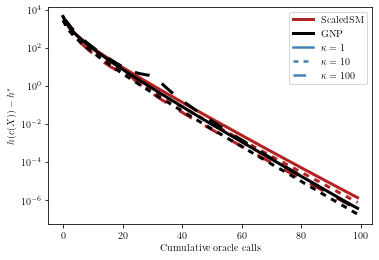

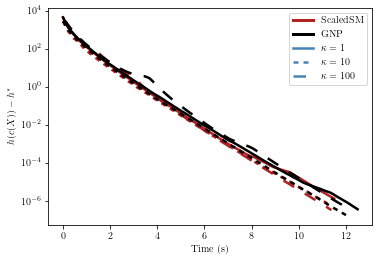

In [3]:
# make a dictionary of colors for the methods
colors = {"Polyak": "firebrick", "ScaledSM": "firebrick", "GNP": "black"}
# make a dictionary of markers for the condition numbers
markers = {1: "o", 10: "s", 100: "^"}
# instead of markers do a different kind of dashes
dashes = {1: (None, None), 10: (2, 2), 100: (5, 5)}

for method in methods:
    for cond_num in cond_nums:
        plt.semilogy(losses_dict[(method, cond_num)], color=colors[method], dashes=dashes[cond_num], linewidth=3)
plt.xlabel("Cumulative oracle calls")
plt.ylabel(r"$h(c(X)) - h^\ast$")
# legend
# make a list of lines for the legend
lines = []
# make a list of labels for the legend
labels = []
# iterate over the methods
# need to import the matplotlib.lines.Line2D
from matplotlib.lines import Line2D
for method in methods:
    # make a line for the method
    line = Line2D([0], [0], color=colors[method], linewidth=3)

    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(method)
# iterate over the condition numbers
for cond_num in cond_nums:
    # make a line for the condition number
    line = Line2D([0], [0], color="steelblue", dashes=dashes[cond_num], linewidth=2.5)
    # add the line to the list of lines
    lines.append(line)
    # add the label to the list of labels
    labels.append(r"$\kappa = " + str(cond_num) + "$")
plt.legend(lines, labels, loc="upper right")
# plt.legend(loc="lower right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_oracle_calls
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment1_scaledSM_vs_gnp_oracle_calls.pdf")
# provide a bit more room on the left so the label is not cut off
plt.show()

# make the legend
for method in methods:
    for cond_num in cond_nums:
        plt.semilogy(times_dict[(method, cond_num)], losses_dict[(method, cond_num)], color=colors[method], dashes=dashes[cond_num], linewidth=2.5)
plt.xlabel("Time (s)")
plt.ylabel(r"$h(c(X)) - h^\ast$")
plt.legend(lines,labels, loc="upper right")
# save the figure in the figures folder with the name Experiment1_polyak_vs_gnp_time
plt.subplots_adjust(left=0.15)
plt.savefig("figures/Experiment1_scaledSM_vs_gnp_time.pdf")
plt.show()